# Chapter 19. Clustering

In [22]:
from __future__ import division
from linear_algebra import squared_distance, vector_mean, distance
import math, random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

Most of the algorithms in this book are what's known as [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning), meaning that they train with a set of labeled data and use that as the basis for making predictions about new, unlabeled data.  
Clustering, however, is an example of [unsupervised learning](https://en.wikipedia.org/wiki/Unsupervised_learning), in which we work with completely unlabeled (or ignored/disregarded) data.

## The Idea

Whenever you look at some sort of data, it's likely that the data will somehow form [clusters](https://en.wikipedia.org/wiki/Cluster_analysis).  
A data set showing where millionaires live probably has clusters in places like San Francisco, Beverly Hills, and Manhattan.  
A data set showing how many hours people work each week probably has a cluster around 40.  
Unlike some of the problems that this book has examined, there is generally no 'correct' clustering.  
An alternative clustering scheme might group "bored retirees" with "avid golfers" and others with "RV owners".  
Neither scheme is necessarily more correct -- instead, each is likely more optimal with respect to it own "how good are the clusters?" metric.  
Furthermore, clusters won't label themselves.  
You will have to do that by looking at the data underlying each one.

## The Model

For us, each `input` will be a vector in $d$-dimensional space (which, as usual, we will represent as a list of numbers).  
Our goal will be to identify clusters of similar inputs and (sometimes) to find a representative value for each cluster.  
For example, each input could be (a numeric vector that somehow represents) the title of a blog post, in which case the goal might be to find clusters of similar posts, perhaps in order to understand what our users our blogging about.  
Or imagine that we have a picture containing thousands of (`red`, `green`, `blue`) colors and that we need to screen-print a 10-color version of it.  
Clustering can help us choose 10 colors that will minimize the total "color error."

One of the simplest clustering methods is [k-means](https://en.wikipedia.org/wiki/K-means_clustering), in which the number of clusters $k$ is chosen in advance, after which the goal is to partition the inputs into sets $S_1, S_2, \ldots, S_k$ in a way that minimizes the total sum of squared distances from each point to the mean of the assigned cluster.  
There are many ways to assign $n$ points to $k$ clusters, which means that finding an optimal clustering is a challenging problem.  
For instructive purposes, we can settle for an iterative algorithm that usually finds a good clustering:
1. Start with a set of $k-means$, which are points in a $d$-dimensional space.
2. Assign each point to the mean to which it is closest.
3. If no point's assignment has changed, stop and keep the clusters.
4. If some point's assignment has changed, recompute the means and and return to step 2.

Using the `vector_mean` function from Chapter 4, we can create a class that does this:

In [23]:
class KMeans:
    """ performs k-means clustering """
    def __init__(self, k):
        self.k = k         # number of means
        self.means = None  # means of the clusters
        
    def classify(self, input):
        """ return the index of the cluster closest to the input """
        return min(range(self.k), key=lambda i: squared_distance(input, self.means[i]))
    
    def train(self, inputs):
        # choose k random points as the initial means
        self.means = random.sample(inputs, self.k)
        assignments = None
        
        while True:
            # find new assignments
            new_assignments = map(self.classify, inputs)
            # if no assignments have changed, we're done
            if assignments == new_assignments:
                return
            # otherwise, keep the new assignments
            assignments = new_assignments
            # and calculate new means based on the new assignments
            for i in range(self.k):
                # find all of the points assigned to cluster i
                i_points = [p for p, a in zip(inputs, assignments) if a == i]
                # make sure i_points is not empty so we're not dividing by zero
                if i_points:
                    self.means[i] = vector_mean(i_points)

Let's take a look at how this works.

## Example: Meetups

To celebrate DataSciencester's growth, your VP of User Rewards wants to organize some meetups for your hometown users.  
You know the locations of all of your hometown users:

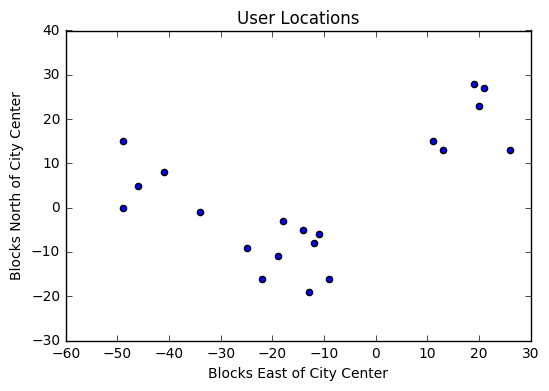

In [24]:
inputs = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],[-34,-1],[11,15],[-49,0],
[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]

# Make a plot of the users based on their location

xs, ys = zip(*inputs)  # https://docs.python.org/2/library/functions.html#zip
plt.scatter(xs, ys)
plt.title("User Locations")
plt.xlabel("Blocks East of City Center")
plt.ylabel("Blocks North of City Center")
plt.show()

and she would like you to choose meetup locations that make it convenient for everyone to attend.  
Depending on how you look at the scatterplot above, you probably see two or three clusters.  
This is fairly easy to do with only two dimensions -- more dimensions make seeing the clusters more difficult.  
Now say that she has enough in her budget for three meetups, which means we can try:

In [25]:
random.seed(0)
clusterer = KMeans(3)
clusterer.train(inputs)
print clusterer.means

[[-43.800000000000004, 5.4], [-15.888888888888888, -10.333333333333332], [18.333333333333332, 19.833333333333332]]


The results are three clusters centered at [-44, 5], [-16, -10], and [18, 20] (which will be plotted later in the chapter), so you can look for meetup venues near those locations.  
You present your results tothe VP, who now tells you that she only has enough budget money for *two* meetups.  
"No problem," you say:

In [26]:
random.seed(0)
clusterer = KMeans(2)
clusterer.train(inputs)
print clusterer.means

[[-25.857142857142854, -4.714285714285714], [18.333333333333332, 19.833333333333332]]


According to your new results (which, again, will be plotted later), one meetup should still be near [18, 20], but now the other one should be near [-26, -5].

## Choosing k

In the previous example, the choice of $k$ was driven by factors outside of our control.  
In general, this won't be the case.  
There are many [different ways to choose $k$](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set), and we'll demonstrate one known as the "[elbow method](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_elbow_method)".   
The elbow method involves plotting the sum of squared errors between each point and the mean of its cluster as a function of $k$ and looking at where the graph 'bends':

In [27]:
def squared_clustering_errors(inputs, k):
    """ finds the total squared error from k-means clustering the inputs """
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = map(clusterer.classify, inputs)
    return sum(squared_distance(input, means[cluster]) for input, cluster in zip(inputs, assignments))

Now let's plot from one up to len(inputs) clusters:

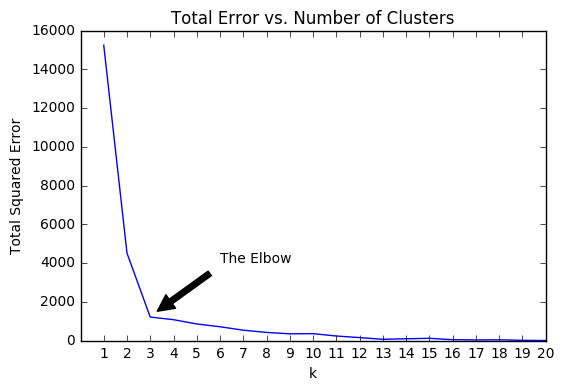

In [28]:
ks = range(1, len(inputs) + 1)
errors = [squared_clustering_errors(inputs, k) for k in ks]

plt.plot(ks, errors)
plt.xticks(ks)
plt.title("Total Error vs. Number of Clusters")
plt.xlabel("k")
plt.ylabel("Total Squared Error")
plt.annotate("The Elbow", xy=(3, 1250), xytext=(6, 4000),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.show()

This method seems to agree with our original hypothesis that 3 is the 'right' number of clusters.

## Example: Clustering Colors

The VP of Swag has designed attractive DataSciencester stickers that you can hand out at the meetups.  
Unfortunately, your printer can only handle five colors at a time.  
Since the VP of Art is on sabbatical, the VP of Swag asks if there is some way that you can take her design and modify it so that it contains only five colors.  
Yeah, I know; let's do this.

Computer images can be represented as two-dimensional arrays of pixels, where each pixel is itself a three-dimensional vector (`red`, `green`, `blue`) indicating its color.  
Creating a five-color version of the image then entails:
1. Choosing five colors.
2. Assigning one of those colors to each pixel.
It turns out that this is a great task for k-means clustering, which can partition the pixels into five clusters in red-green-blue space.  
If we then recolor the pixels in each cluster to the mean color, we're done.

To start with, we need a way to load an image into Python, and we can do this using `matplotlib`.  
We are going to turn this image (courtesy of [Enfuzed](http://enfuzed.com/free-flat-social-media-icons/)):

![social_media_icons](img/social_media_icons.png)

into arrays that our computer can understand and work with:

In [29]:
import matplotlib.image as mpimg

path_to_png_file = r"img/social_media_icons.png"  
# http://www.feedtip.com/wp-content/uploads/2013/12/Flat-Social-Media-Icons.png
img = mpimg.imread(path_to_png_file)
img

array([[[ 0.94901961,  0.94901961,  0.94901961,  1.        ],
        [ 0.94901961,  0.94901961,  0.94901961,  1.        ],
        [ 0.94901961,  0.94901961,  0.94901961,  1.        ],
        ..., 
        [ 0.94901961,  0.94901961,  0.94901961,  1.        ],
        [ 0.94901961,  0.94901961,  0.94901961,  1.        ],
        [ 0.94901961,  0.94901961,  0.94901961,  1.        ]],

       [[ 0.94901961,  0.94901961,  0.94901961,  1.        ],
        [ 0.94901961,  0.94901961,  0.94901961,  1.        ],
        [ 0.94901961,  0.94901961,  0.94901961,  1.        ],
        ..., 
        [ 0.94901961,  0.94901961,  0.94901961,  1.        ],
        [ 0.94901961,  0.94901961,  0.94901961,  1.        ],
        [ 0.94901961,  0.94901961,  0.94901961,  1.        ]],

       [[ 0.94901961,  0.94901961,  0.94901961,  1.        ],
        [ 0.94901961,  0.94901961,  0.94901961,  1.        ],
        [ 0.94901961,  0.94901961,  0.94901961,  1.        ],
        ..., 
        [ 0.94901961,  0

Behind the scenes, `img` is a NumPy array of [RGBA values](https://en.wikipedia.org/wiki/RGBA_color_space), but for our purposes, we can treat it as a list of lists of lists.  
`img[i][j]` is the pixel in the $i$th row and $j$th column, and each pixel is a list `[red, green, blue]` of numbers between 0 and 1 indicating the [color of that pixel](https://en.wikipedia.org/wiki/RGB_color_model#Numeric_representations):

In [30]:
top_row = img[0]
top_left_pixel = top_row[0]
red, green, blue, alpha = top_left_pixel
print red, green, blue, alpha

0.94902 0.94902 0.94902 1.0


In particular, we can get a flattened list of all of the pixels with:

In [31]:
pixels = [pixel for row in img for pixel in row]

and then feed them to our clusterer:

In [32]:
clusterer = KMeans(5)
clusterer.train(pixels)  # this will take a while

Once it finishes, we just construct a new image with the same format:

In [33]:
def recolor(pixel):
    cluster = clusterer.classify(pixel)  # index of the closest cluster
    return clusterer.means[cluster]      # mean of the closest cluster
# recolor each row of pixels for each row in the image
new_img = [[recolor(pixel) for pixel in row] for row in img]  # this also takes a while

and display it using plt.imshow():

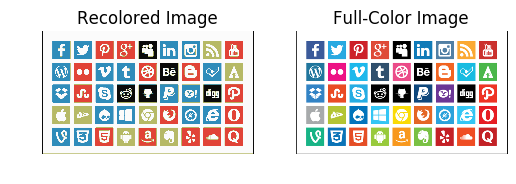

In [40]:
# f, ax = plt.subplots()
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(new_img)
ax1.axis('off')
ax1.set_title("Recolored Image")
ax2.imshow(img)
ax2.axis('off')
ax2.set_title("Full-Color Image")
plt.show()

## Bottom-up Hierarchical Clustering